# 야구선수 연봉 예측
### 4조 : 임주나, 이윤석, 이기욱
---
![Baseball](./Baseball_1.jpg )
___

## Purpose
---
![Baseball](./Ryu.jpg )
___

 - 류현진, KBO에서의 마지막 리그, 2012년 한화에서의 연봉은 4억 3천만원
 - 메이저리그 연봉 600만달러 한화로 61여억원으로 약 15배의 연봉을 받게 됨
 - 스포츠에서는 어떻게 연봉이 책정될까?
 - 정말 능력 위주로 연봉이 책정될까?

## Goal

 > **Feature** KBO 기록실에 기재되어 있는 타자의 데이터를 기반으로
 
 > **Target**  내년 연봉을 예측


## Preparation
 > **데이터 수집**
  - statiz 웹사이트에서 타자의 연봉(Y) 및 기록(X)를 크롤링
  
 > **분석 방법**
  - 회귀분석
   - 가중평균을 이용한 회귀분석
   - PCA를 이용한 주성분 회귀분석

## Task Plan

### 데이터수집 > 전처리 > 모델 선택 > 계수추정 > 평가 > 개선 > 최종 성능 평가


---
#### 1. 데이터
 - 데이터는 야구 선수 중 타자만을 대상으로 하였으며, 100타석 이상을 기준으로 데이터를 크롤링함.
 - 데이터는 **Real number**로 이루어져 있음.
 - 예) 타율 : 0.313, 타석 : 525, 연봉 2700 (단위 : 만원)
 - 데이터의 유효숫자는 최대 소수점 6자리로 하였으며, 7번째부터는 반올림으로 계산함. 

| X | Description | C/R | Class Label | Contraint |
| :---: | :--- | :---: | :---: | :---: |
| X0 | 타석, 타자가 타석에 선 수 | R | TASUK | X1>=0
| X1 | 타수, 타석 - 볼넷 - 데드볼 - 루타 - 희생타 | R |TASU | X1>=0
| X2 | 득점, 타자가 홈을 밟은 횟수 | R | TASU | X1>=0
| X3 | 안타, 아웃되지 않은 모든 진루타 | R | ANTA | X1>=0
| X4 | 2루타, 타격시 2루까지 가는 경우 | R | 2TA | X5>=0
| X5 | 3루타, 타격시 3루까지 가는 경우 | R | 3TA | X6>=0
| X6 | 홈런, 타격시 홈까지 가는 경우 | R | HOMERUN | X7>=0
| X7 | 루타, 단타 + 2루타\*2 + 3루타\*3 + 홈런\*4 | R | ALLTA | X8>=0
| X8 | 타점, 타자가 플레이해 주자가 득점 | R | TAJUM | X9 >=0
| X9 | 도루, 주자가 다음 베이스로 가는 경우 | R | DORU | X10 >=0
| X10 | 도루실패 | R | DOSIL | X11 >=0
| X11 | 희생타, 희생번트 + 희생플라이 | R | HEUITA | X12 >= 0
| X12 | 볼넷 | R | BALLNET | X13 >= 0
| X13 | 사사구, 몸에 맞은 공 | R | SAGU | X14 >= 0
| X14 | 고의사구, 상대 투수가 고의적으로 볼넷 | R | GOSA | X15 >= 0
| X15 | 삼진, 스트라이크 3번으로 아웃 | R | SAMJIN | X16 >= 0
| X16 | 병살, 한번의 타격으로 2아웃 되는 경우 | R | BYUNGSAL | X17>=0
| X17 | 타율, 한 게임 동안 친 안타의 평균 | R | TAYUL | X19>=0
| X18 | 출루율, 타자가 베이스로 나가는 평균율 | R | CHULRU | X20>=0
| X19 | 장타율, 타격시 멀리 가는 평균율 | R | JANGTA | X21>=0
| X20 | 경력, 프로야구 경력 | R | CAREER | X22>=0
| **Y** | **연봉** | R | **SALARY** | Y>=0


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import statsmodels.api as sm
import matplotlib.pyplot as plt

from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA

## 데이터 불러오기
- 사용된 데이터는 2015년 타자 경기기록과 2016년 연봉

In [10]:
#X 및 Y list
k = 'TASUK,TASU,DEUKJUM,ANTA,2TA,3TA,HOMERUN,ALLTA,TAJUM,DORU,DOSIL,BALLNET,SAGU,GOSA,SAMJIN,BYUNGSAL,HEUITA,HEUIBI,TAYUL,CHULRU,JANGTA,CAREER,SALARY'
a = list(k.split(','))

#2015년 타자 데이터
df1 = pd.read_csv('salary_prediction_taja_add_career.csv')

df1.head()
dfX = pd.DataFrame(df1, columns = a[:-2])

dfX['HEUITA'] += dfX['HEUIBI']

del dfX['HEUIBI']

df_C = pd.DataFrame(df1, columns = ['CAREER'])
dfY = pd.DataFrame(df1, columns = ['SALARY'])

### 데이터 전처리
 - 정규화(normalize) 사용

In [11]:
k1 = 'TASUK,TASU,DEUKJUM,ANTA,2TA,3TA,HOMERUN,ALLTA,TAJUM,DORU,DOSIL,BALLNET,SAGU,GOSA,SAMJIN,BYUNGSAL,HEUITA,TAYUL,CHULRU,JANGTA'
b = list(k1.split(','))

result = []
for i in b:
    result.append(normalize(dfX[i]).T)

#한 선수당 1 column인 data table    
db_batter_index = pd.DataFrame(np.hstack(result), columns = b)

c:\python27\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
c:\python27\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
c:\python27\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
c:\python27\lib\site-packages\skle

## Feature(X) 끼리의 상관정도
 - 색이 진할수록 상관도가 높음

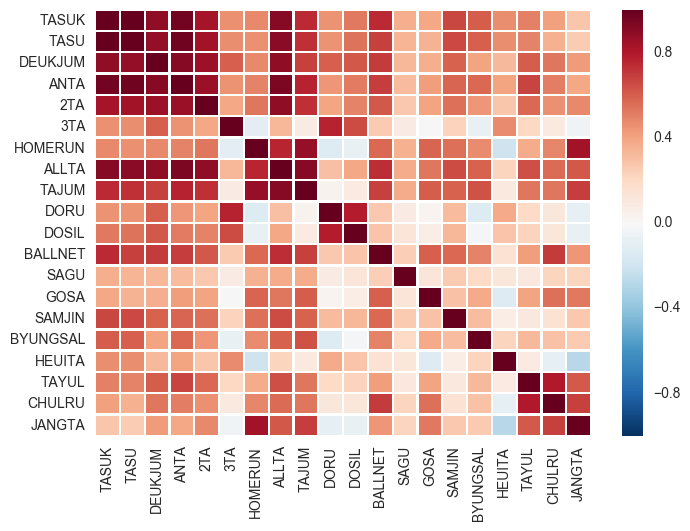

In [12]:
# 상관계수
corr_data = pd.DataFrame.corr(db_batter_index)
sns.heatmap(corr_data, annot=False, linewidths=1)
plt.show()

### 상관관계가 깊으면 일반 선형 회귀분석을 사용할 수 없음
 - 전제조건이 각 X가 독립이여야함.

### 따라서 상관관계에 따른 그룹 평균값을 이용한 가중평균 회귀분석과 PCA 분석을 실시함

## 가중평균을 이용한 회귀분석

### 상관계수 그룹화

In [13]:
group1 = (db_batter_index['TASUK'] + db_batter_index['TASU'] + db_batter_index['DEUKJUM'] + db_batter_index['ANTA'] \
           + db_batter_index['2TA'] + db_batter_index['HOMERUN'] + db_batter_index['ALLTA'] + db_batter_index['TAJUM'] \
           + db_batter_index['BALLNET'] + db_batter_index['SAMJIN'] + db_batter_index['BYUNGSAL'] + db_batter_index['HEUITA'] \
           + db_batter_index['TAYUL'] + db_batter_index['CHULRU'] + db_batter_index['JANGTA'])/15
group2 = (db_batter_index['3TA'] + db_batter_index['SAGU'])/2
group3 = (db_batter_index['DORU'] + db_batter_index['GOSA'])/2
group4 = db_batter_index['DOSIL']

### 각 그룹의 특성에 따라 공격력(Attack), 체력(Strength), 기동력(Mobility), 실수(Missing)로 나눔

In [16]:
score = pd.concat([group1, group2, group3, group4], axis = 1)
score.columns = ['Attack', 'Strength', 'Mobility', 'Missing']

In [17]:
df_career = pd.DataFrame(np.log(df_C['CAREER']+1).T, columns = ['CAREER']) # 0값을 없애기 위해 1을 더해 로그화함
salary_prediction_w = pd.concat([score, df_career, np.log(dfY)], axis = 1)
salary_prediction_w.head()

,Attack,Strength,Mobility,Missing,CAREER,SALARY
0,0.175357,0.193507,0.334120,0.164226,0.693147,11.736069
1,0.115393,0.111183,0.104708,0.205282,1.945910,10.126631
2,0.150579,0.034612,0.045882,0.061585,2.397895,11.002100
3,0.141837,0.129507,0.010438,0.000000,2.484907,11.225243
4,0.131625,0.138978,0.111992,0.082113,0.693147,9.680344


### R-style Formula를 통해 최적화된 값을 찾음

In [18]:
regression_w = 'SALARY ~ np.log(Attack) + Mobility + Missing + CAREER'
model_salary_w = sm.OLS.from_formula(regression_w, data = salary_prediction_w)
result_salary_w = model_salary_w.fit()
print (result_salary_w.summary())

                            OLS Regression Results                            
Dep. Variable:                 SALARY   R-squared:                       0.651
Model:                            OLS   Adj. R-squared:                  0.633
Method:                 Least Squares   F-statistic:                     37.29
Date:                Mon, 19 Dec 2016   Prob (F-statistic):           1.41e-17
Time:                        18:46:36   Log-Likelihood:                -72.288
No. Observations:                  85   AIC:                             154.6
Df Residuals:                      80   BIC:                             166.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------
Intercept         13.1855      0.706     18.

### PCA와 똑같이 아웃라이어를 제거하였으나 R-Square 값이 0.6 이상을 볼 수 없었음

=========================================================================================================

## PCA를 이용한 주성분 회귀분석

## PCA 갯수를 정하기

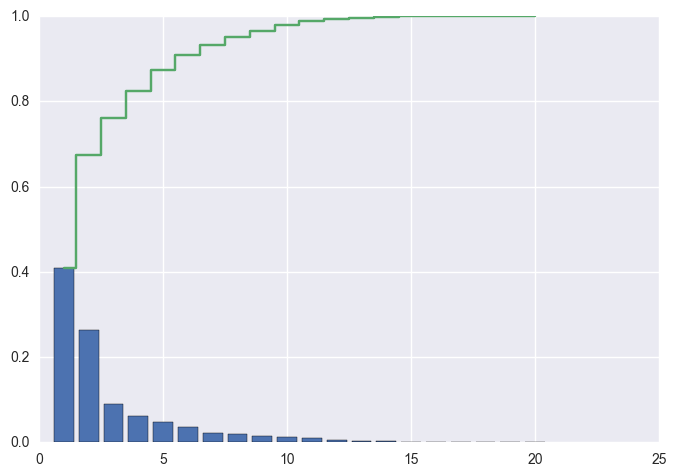

In [19]:
pca = PCA().fit(db_batter_index)
var = pca.explained_variance_
cmap = sns.color_palette()

plt.bar(np.arange(1,len(var)+1), var/np.sum(var), align="center", color=cmap[0])
plt.step(np.arange(1,len(var)+1), np.cumsum(var)/np.sum(var), where="mid", color=cmap[1])
plt.show()

In [20]:
#PCA setting
from sklearn.decomposition import PCA
pca = PCA(n_components=5)
pca.fit(db_batter_index)
#How many PCA do I need to use?
# Over 80% of accumulated explaining ability
k = pca.explained_variance_ratio_
sum = k[0] + k[1] + k[2]
print k
print '='*20
print 'Average :' + str(sum)

[ 0.41000883  0.26295137  0.08885089  0.06256719  0.04804775]
Average :0.761811088576


### PCA 3개로 76%의 설명력을 가질 수 있음

In [21]:
X_pca = PCA(n_components=3)
X_pca.fit_transform(db_batter_index)

dfX_pca = pd.DataFrame(X_pca.fit_transform(db_batter_index))
dfX_pca.columns = ['PC1', 'PC2', 'PC3']

df_pca_analysis = pd.concat([dfX_pca, pd.DataFrame(normalize(df_C['CAREER']).T), np.log(dfY)], axis = 1)
df_pca_analysis.columns = ['PC1', 'PC2', 'PC3', 'CAREER', 'SALARY']

c:\python27\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


In [22]:
regression = 'SALARY ~ PC1 + PC2 + I(PC3 ** 2) + CAREER'
model_salary = sm.OLS.from_formula(regression, data = df_pca_analysis)
result_salary = model_salary.fit()
print (result_salary.summary())

                            OLS Regression Results                            
Dep. Variable:                 SALARY   R-squared:                       0.681
Model:                            OLS   Adj. R-squared:                  0.665
Method:                 Least Squares   F-statistic:                     42.64
Date:                Mon, 19 Dec 2016   Prob (F-statistic):           4.15e-19
Time:                        18:49:35   Log-Likelihood:                -68.492
No. Observations:                  85   AIC:                             147.0
Df Residuals:                      80   BIC:                             159.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
Intercept       9.4212      0.137     68.812      

# 아웃라이어

### 선형성을 높이기 위해 아웃라이어 찾기 및 제거 시도

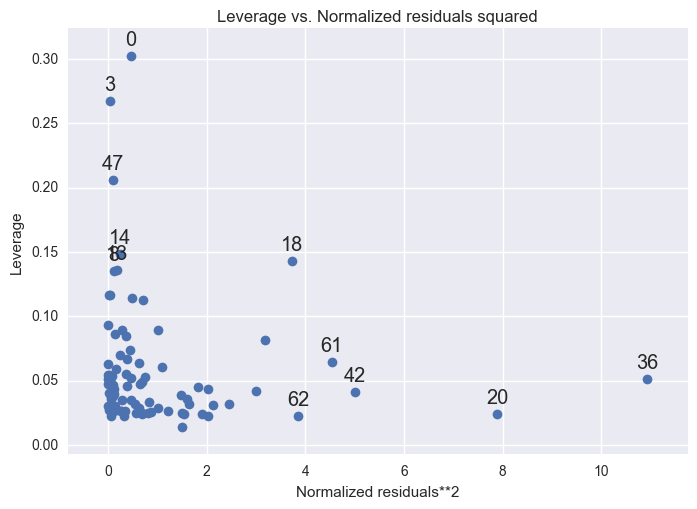

In [23]:
sm.graphics.plot_leverage_resid2(result_salary)
plt.show()

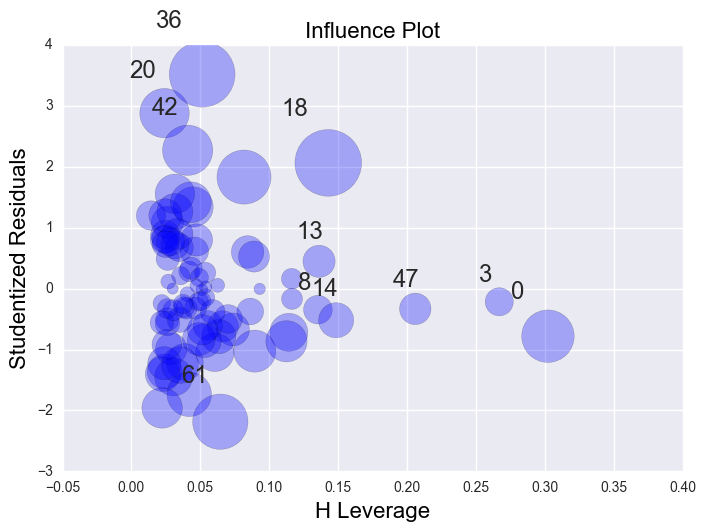

In [24]:
sm.graphics.influence_plot(result_salary, plot_alpha=0.3)
plt.show()

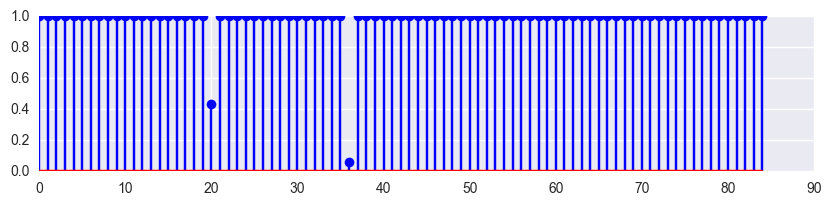

In [25]:
plt.figure(figsize=(10, 2))
plt.stem(result_salary.outlier_test().ix[:, -1])
plt.show()

### 위 Figure들을 통해 20번과 36번을 제거하고 계속 해보고자 함

## 아웃라이어 제거

In [26]:
df_pca_analysis2 = df_pca_analysis.drop(36)
df_pca_analysis3 = df_pca_analysis2.drop(20)

## 제거 후 OLS Report

In [27]:
regression = 'SALARY ~ PC1 + PC2 + I(PC3 ** 2) + CAREER'
model_salary = sm.OLS.from_formula(regression, data = df_pca_analysis3)
result_salary = model_salary.fit()
print (result_salary.summary())

                            OLS Regression Results                            
Dep. Variable:                 SALARY   R-squared:                       0.746
Model:                            OLS   Adj. R-squared:                  0.733
Method:                 Least Squares   F-statistic:                     57.36
Date:                Mon, 19 Dec 2016   Prob (F-statistic):           1.76e-22
Time:                        18:53:58   Log-Likelihood:                -56.811
No. Observations:                  83   AIC:                             123.6
Df Residuals:                      78   BIC:                             135.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
Intercept       9.3014      0.124     74.814      

### 아웃라이어 제거를 통해 R-Square 값이 향상된 것을 알 수 있음.
### Formula:  $PC1 + PC2 + (PC3^2) + CAREER = SALARY$ 를 최종확정하고 dataset에 적용

In [28]:
df_pca_analysis4 = df_pca_analysis3
df_pca_analysis4['PC3'] = (df_pca_analysis3['PC3'] ** 2)

## Cross Validation
 - Label K Fold 사용
 - Cross Validation 하기 전에 outlier를 제거한 index를 Median으로 채움

In [29]:
from sklearn.preprocessing import Imputer
from sklearn.cross_validation import LabelKFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

c:\python27\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Nan 값을 처리하기 위해 중간값을 적용함

In [30]:
imp = Imputer(missing_values='NaN', strategy='median', axis=0)
pca_analysis4 = imp.fit_transform(df_pca_analysis3)

df_pca_analysis5 = pd.DataFrame(pca_analysis4, columns = ['PC1', 'PC2', 'PC3', 'CAREER', 'SALARY'])
df_pca_analysis_cv_x = pd.DataFrame(df_pca_analysis5, columns = ['PC1', 'PC2', 'PC3', 'CAREER'])
df_pca_analysis_cv_y = pd.DataFrame(df_pca_analysis5, columns = ['SALARY'])

In [34]:
cv = LabelKFold(df_pca_analysis_cv_y['SALARY'], n_folds=3)
model = LinearRegression()
scores = np.zeros(3)

for i, (train_index, test_index) in enumerate(cv):
    X_train = df_pca_analysis_cv_x.ix[train_index]
    y_train = df_pca_analysis_cv_y['SALARY'][train_index]
    X_test = df_pca_analysis_cv_x.ix[test_index]
    y_test = df_pca_analysis_cv_y['SALARY'][test_index]
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    #scores[i] = mean_squared_error(y_test, y_pred)
    scores[i] = r2_score(y_test, y_pred)

print '='*30
print '평균 R-Square값:' + str(np.mean(scores))
print '='*30

평균 R-Square값:0.709425651687


### 결과값
 - K Fold로 dataset을 3등분 하였기 때문에 예측결과는 85개 전부가 나오지는 않음

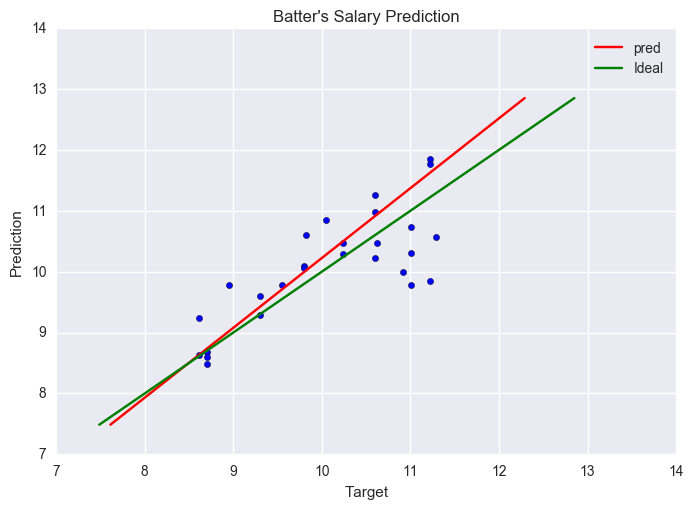

In [36]:
plt.scatter(y_test, y_pred)
plt.title('Batter\'s Salary Prediction')
plt.ylabel('Prediction')
plt.xlabel('Target')
xx = np.linspace(np.min(y_test) - 1, np.max(y_test) + 1, 1000)
yy = np.linspace(np.min(y_pred) - 1, np.max(y_pred) + 1, 1000)
pred = plt.plot(xx, yy, 'r-', label='pred')
Ideal = plt.plot(yy, yy, 'g-', label='Ideal')
plt.legend()
plt.show()

## 한계점
    1. 전체선수 222명 중 타석 100타석 이상인 선수들 85명으로 Dataset이 부족한 영향이 있을 것이라고 판단됨.
    2. 야구선수 중 경력 7년 이후 FA 시장에 나와 재계약 후 연봉이 급등하는 경우가 많아 이점이 고려되지 않았음
    3. 선수의 경기력 이외 나이, 포지션, 용병 등 영향을 끼치는 변수가 더 존재할 것으로 판단됨.
    4. 아웃라이어로 22(허경민), 36(박한이)의 경우 특이 케이스로 판단해 예외하고 진행하였으나 아웃라이어로서의 판단 기준이 모호했음